# Лабораторная работа №7 Предсказание пола клиента по транзакциям
## Чередова Александра
### Считывание данных

In [45]:
import pandas as pd
import numpy as np

import xgboost as xgb
import re
import matplotlib.pyplot as plt

#from tqdm.notebook import tqdm_notebook
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

## Подготовка данных


In [46]:
# Считываем данные
tr_mcc_codes = pd.read_csv('./data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('./data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('./data/transactions.csv', index_col='customer_id')
df = transactions

# Разделение строки по пробелу и создание нового столбца
df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразование значения в числовой формат
df['day_number'] = df['day_number'].astype(int)

df.describe()

,mcc_code,tr_type,amount,day_number
count,6.849346e+06,6.849346e+06,6.849346e+06,6.849346e+06
mean,5.589776e+03,2.517356e+03,-2.054285e+04,2.434603e+02
std,6.035857e+02,2.270108e+03,4.777528e+05,1.303082e+02
min,7.420000e+02,1.000000e+03,-1.459845e+08,0.000000e+00
25%,5.200000e+03,1.030000e+03,-2.245916e+04,1.330000e+02
50%,5.641000e+03,1.110000e+03,-5.480030e+03,2.510000e+02
75%,6.010000e+03,2.370000e+03,-1.122960e+03,3.560000e+02
max,9.402000e+03,8.146000e+03,1.459845e+08,4.560000e+02


In [47]:
gender_train = pd.read_csv('./data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))
# gender_test = pd.read_csv('./data/gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [48]:
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


## Формирование признаков

In [62]:
# Преобразуем столбец tr_datetime в формат даты
transactions_train['tr_datetime'] = pd.to_datetime(transactions_train['tr_datetime'], errors='coerce')

# Создаем новый столбец с датой
transactions_train['transaction_date'] = transactions_train['tr_datetime'].dt.date

# Группируем по дате и считаем количество транзакций в каждый день
transactions_per_day = transactions_train.groupby('transaction_date').size()

# Выводим результат
print(transactions_per_day)


transaction_date
1973-01-01    7154
1974-01-01    7781
1975-01-01    7770
1976-01-01    7695
1977-01-01    7901
              ... 
2068-01-01    7133
2069-01-01    7160
2070-01-01    8020
2071-01-01    7004
2072-01-01    5839
Length: 68, dtype: int64


In [63]:
# Добавим дополнительные признаки по каждому пользователю в модель.
# Для этого будем анализировать дни недели, часы и состояние дня/ночи.
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample
def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    # ВременнЫе признаки
    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    # Стандартные агрегации, посчитанные на расходах и приходах клиента: 
    # минимум, максимум, среднее, медиана, среднеквадратичное отклонение, количество
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))

    # Типы транзакций 
    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_code_')))
    # Типы mcc кодов
    features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('tr_type_')))

    # ДОПОЛНИТЕЛЬНЫЕ ПАРАМЕТРЫ
    # ....
    
    return pd.concat(features)
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation).unstack(-1)

AttributeError: Can only use .str accessor with string values!

## Построение модели

Функции, которыми можно пользоваться для построения классификатора, оценки его результатов и построение прогноза для тестовой части пользователей

In [64]:
def cv_score(params, train, y_true):
    '''Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)'''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print(f'Cross-validation, ROC AUC: {cv_res.loc[index_argmax]["test-auc-mean"]:.3f}+-{cv_res.loc[index_argmax]["test-auc-std"]:.3f}')
    print(f'Trees: {index_argmax}')
def fit_predict(params, num_trees, train, test, target):
    '''Построение модели + возврат результатов классификации тестовых пользователей'''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission
def draw_feature_importances(clf, top_k=10):
    '''Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

Cross-validation, ROC AUC: 0.679+-0.009
Trees: 73


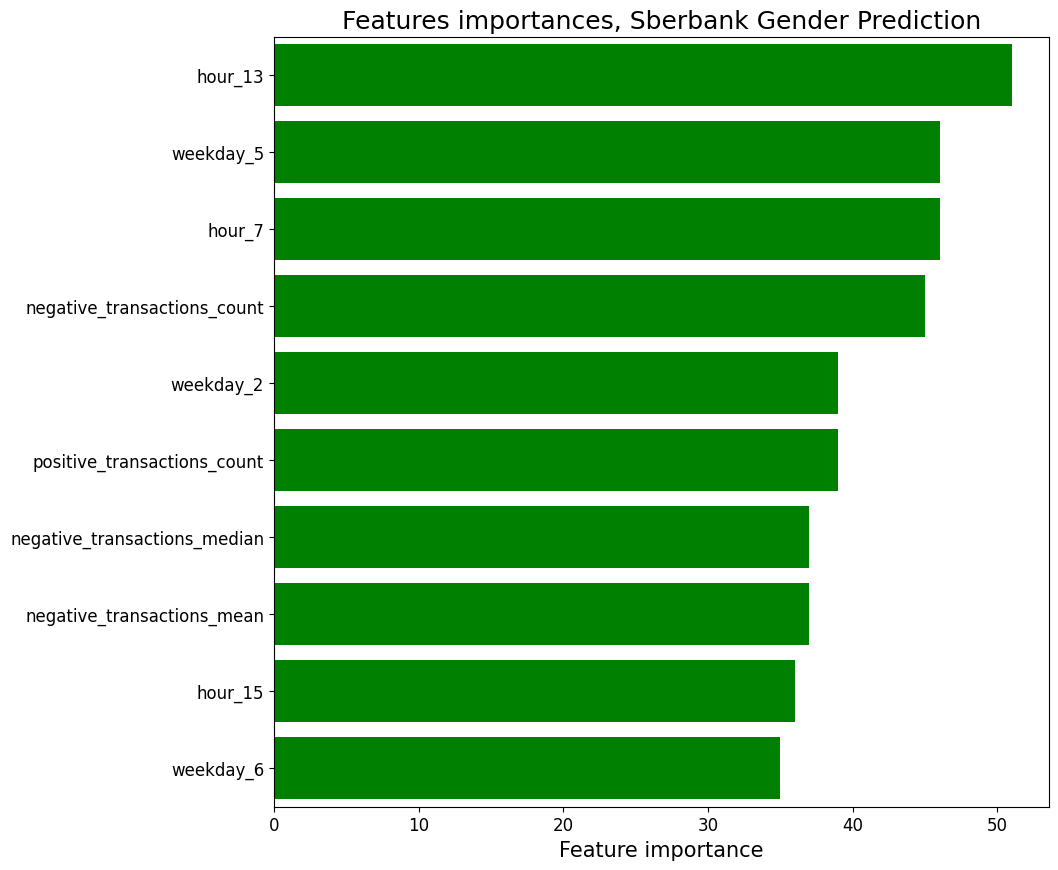

OSError: Cannot save file into a non-existent directory: '..\data'

In [65]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 180, data_train, data_test, target)
draw_feature_importances(clf, 10)
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
submission.to_csv('../data/submission.csv')

In [66]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.683+-0.006
Trees: 78


Cross-validation, ROC AUC: 0.683+-0.006
Trees: 78


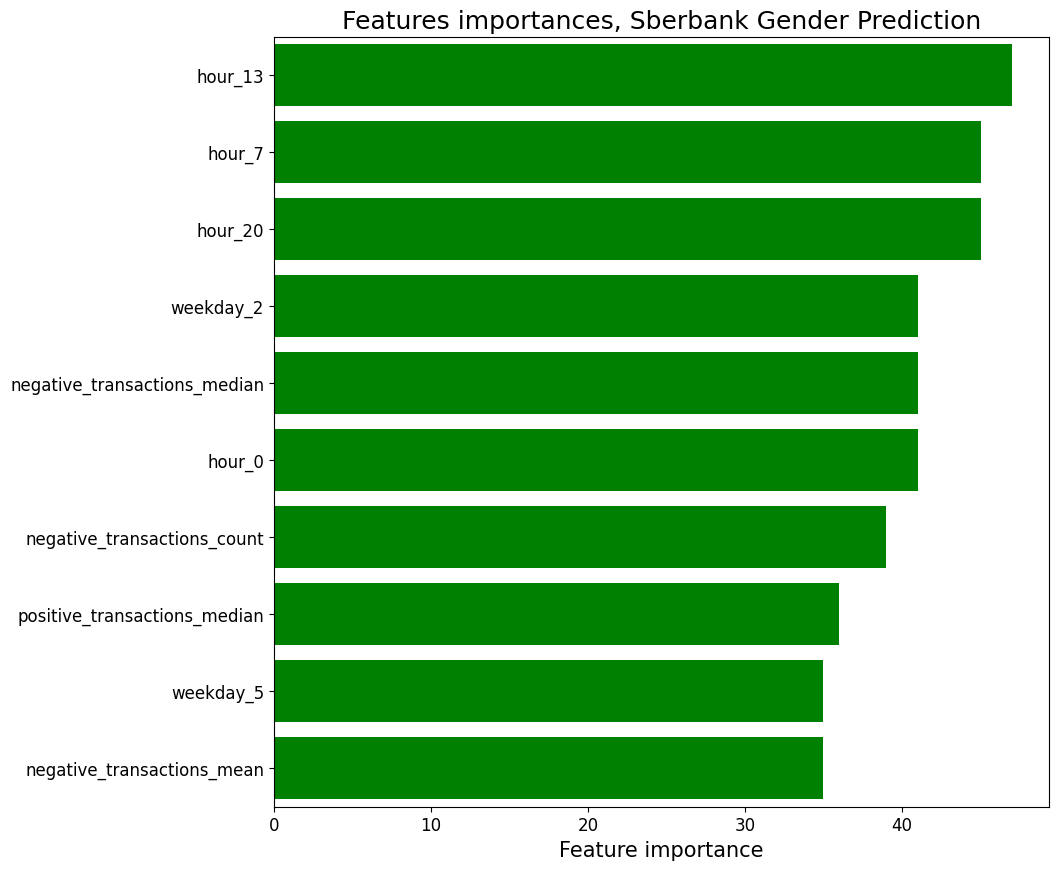

OSError: Cannot save file into a non-existent directory: '..\data'

In [67]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)
### Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 180, data_train, data_test, target)
draw_feature_importances(clf, 10)
# В итоге можем отправить полученное решение на платформу Kaggle. 
# Для этого выгрузим его в *.csv - файл, после чего полученный файл можем загружать в качестве ответа.
submission.to_csv('../data/submission.csv')

In [75]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.9, #######
    'colsample_bytree': 0.9, #######
    
    'gamma': 0.9, # 0.1 # 0.2 # 0.8
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.681+-0.009
Trees: 100


## 1. Связать номер дня с календарем
### 1.1. Найдем день недели

<Figure size 1000x600 with 0 Axes>

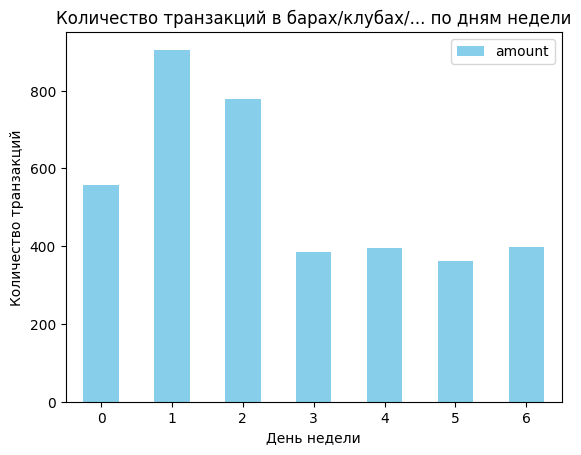

In [20]:
import matplotlib.pyplot as plt

# Выбираем только транзакции с mcc_code == '5813'
# (это код транзакций связанных с местами продажи алкогольных напитков)
filtered_transactions = df[(df['mcc_code'] == 5813) & (df['amount'] < 0)]
filtered_transactions['day_of_week'] = filtered_transactions['day_number'].apply(lambda x: x % 7)

# print(filtered_transactions)
# Группируем по дню недели и считаем количество транзакций в каждый день
transactions_by_day = filtered_transactions.groupby('day_number').agg({"amount":"count"})
transactions_by_weekday = filtered_transactions.groupby('day_of_week').agg({"amount":"count"})
# print(transactions_by_weekday)
# Проверяем, есть ли транзакции для построения графика
if not transactions_by_weekday.empty:
    # Создаем гистограмму
    plt.figure(figsize=(10, 6))
    transactions_by_weekday.head(7).plot(kind='bar', color='skyblue')
    plt.title('Количество транзакций в барах/клубах/... по дням недели')
    plt.xlabel('День недели')
    plt.ylabel('Количество транзакций')
    plt.xticks(rotation=0)
    plt.show()
else:
    print('Нет данных для построения графика.')


На гистограмме можно заметить резкое увеличиение транзакций для дня недели №1. По предварительным/промежуточным наблюдениям, можно предположить, что №1 = пятница, суббота:)


5111- канцелярия
черная пятница
3501 отели


<Figure size 900x500 with 0 Axes>

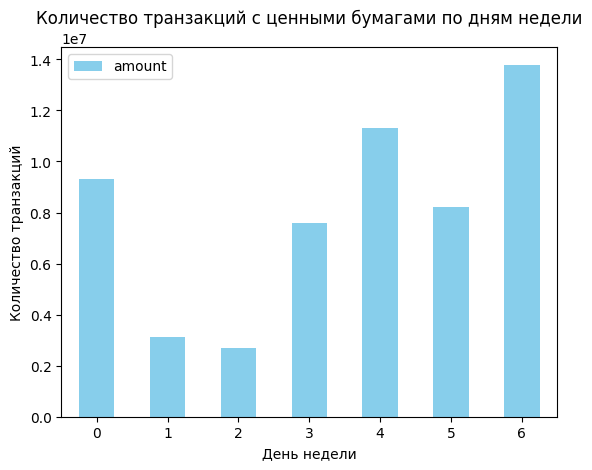

In [29]:
import matplotlib.pyplot as plt

# Выбираем только транзакции с mcc_code == '6211'
# (это код транзакций связанных с ценными бумагами)
filtered_transactions = df[(df['mcc_code'] == 6211) & (df['amount'] < 0)]
filtered_transactions['day_of_week'] = filtered_transactions['day_number'].apply(lambda x: x % 7)

# Make the negative amounts positive
filtered_transactions['amount'] = filtered_transactions['amount'].abs()

# Группируем по дню недели и считаем количество транзакций в каждый день
transactions_by_weekday = filtered_transactions.groupby('day_of_week').agg({"amount":"sum"})

# Проверяем, есть ли транзакции для построения графика
if not transactions_by_weekday.empty:
    # Создаем гистограмму
    plt.figure(figsize=(9, 5))
    transactions_by_weekday.plot(kind='bar', color='skyblue')
    plt.title('Количество транзакций с ценными бумагами по дням недели')
    plt.xlabel('День недели')
    plt.ylabel('Количество транзакций')
    plt.xticks(rotation=0)
    plt.show()
else:
    print('Нет данных для построения графика.')


Вероятно, дни 1 и 2 - выходные, что подтверждает предыдущую теорию

### 0 день - пятница

### 1.2. Найдем дату

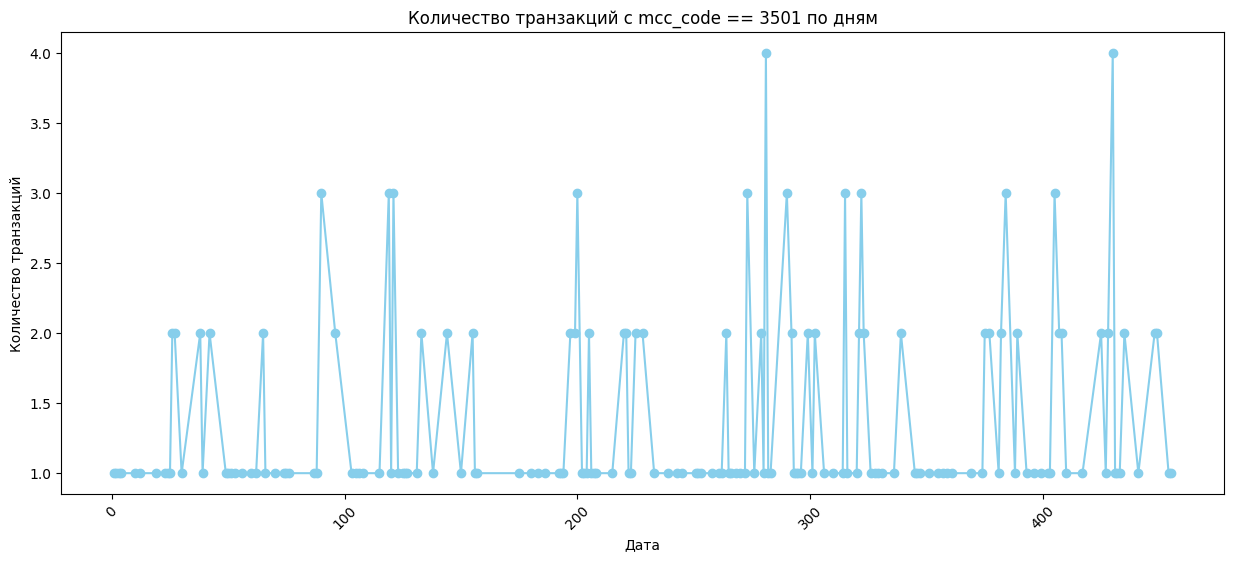

In [23]:
import matplotlib.pyplot as plt

# Выбираем только транзакции с mcc_code == '3501' (отели)
filtered_transactions = df[df['mcc_code'] == 3501]

# Группируем по дате и считаем количество транзакций в каждую дату
transactions_by_date = filtered_transactions.groupby('day_number').size()

# Создаем график
plt.figure(figsize=(15, 6))
transactions_by_date.plot(kind='line', marker='o', linestyle='-', color='skyblue')
plt.title('Количество транзакций с mcc_code == 3501 по дням')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.show()


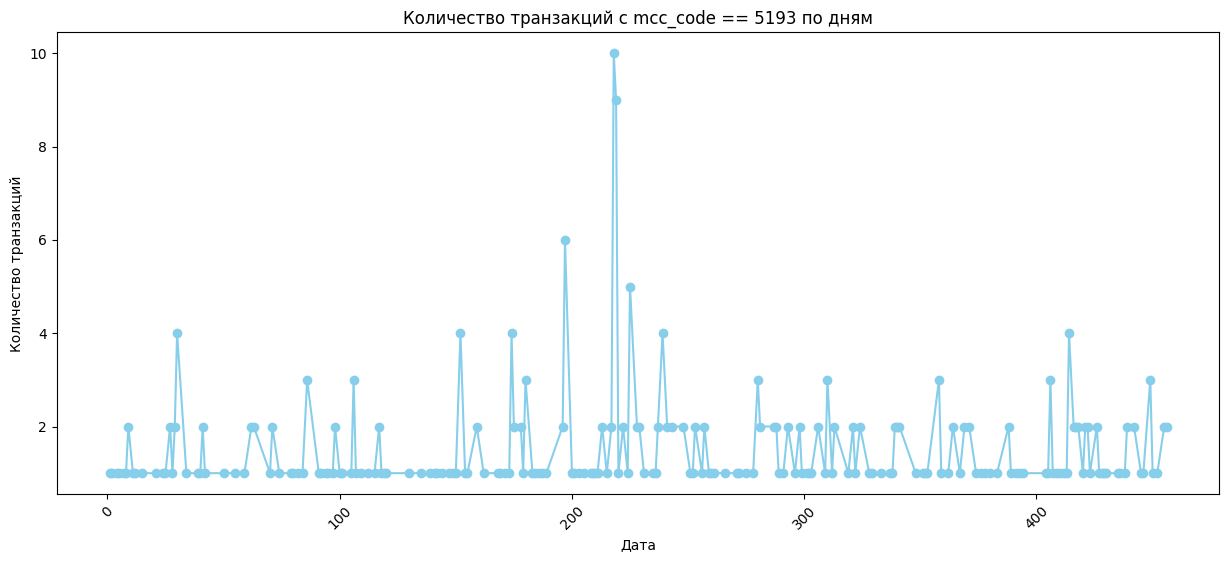

In [24]:
df = transactions

# Разделение строки по пробелу и создание нового столбца
df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

# Преобразование значения в числовой формат
df['day_number'] = df['day_number'].astype(int)

import matplotlib.pyplot as plt

# Выбираем только транзакции с mcc_code == '5193' (цветы)
filtered_transactions = df[df['mcc_code'] == 5193]

# Группируем по дате и считаем количество транзакций в каждую дату

transactions_by_date = filtered_transactions.groupby('day_number').size()

# Создаем графи
plt.figure(figsize=(15, 6))
transactions_by_date.plot(kind='line', marker='o', linestyle='-', color='skyblue')
plt.title('Количество транзакций с mcc_code == 5193 по дням')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.show()


In [25]:
print(transactions_by_date[transactions_by_date > 7])
# 218 - Вероятно 7 матра
# 0 - 1 августа (пятница)
# август 14 года

day_number
218    10
219     9
dtype: int64


От 7 марта нужно сделать 218 "шагов" назад

## Следовательно, измерения начали проводить 1 августа 2014

## 2. Декодировать суммы поступлений и списаний. 


In [77]:
filtered_amounts = df[(df['tr_type'] == 2010) & (df['amount'] < 0)]['amount']
unique_amounts = filtered_amounts.unique()
sorted_unique_amounts = pd.Series(unique_amounts).astype(float).sort_values()

# Найдем разницу в суммах
differences = sorted_unique_amounts.diff()

print(differences)
# Посчитаем количество одинаковых разниц, чтобы найти самые популярные
differences_counts = differences.value_counts()

# Выводим топ-10 самых частых разностей
top_10_differences = differences_counts.head(10)
print("Топ-10 самых частых разностей:")
print(top_10_differences)

1072         NaN
166     36755.54
1054    89836.63
162     22459.15
379     67377.48
          ...   
22       1122.96
902        94.78
60       1028.18
20       1122.95
56       1122.96
Length: 1145, dtype: float64
Топ-10 самых частых разностей:
2245.92     107
2245.92      86
2245.91      77
1122.96      62
2245.91      55
4491.83      44
1122.96      43
11229.58     33
2245.92      32
6737.75      31
Name: count, dtype: int64


Выдвигаем предположение: 

2245.92 - 100 рублей

1122.96 - это 50 рублей, а значит коэффициент равен 22.4592



### $\pi^e$
